In [1]:
import numpy as np
from mayavi import mlab
import matplotlib.pyplot as plt
import pickle

import sys
import os
sys.path.append('..')

import horus as ho

In [2]:
bs, bsh, (nfp, coils, ma, sc_fieldline) = ho.ncsx()

In [ ]:
for coil in coils:
    coil.plot(engine="mayavi", show=False)

mlab.show()

#### Poincare plot

In [ ]:
nfieldlines = 30
phis = [0]    #[(i / 4) * (2 * np.pi / nfp) for i in range(4)]
Rs = np.linspace(ma.gamma()[0, 0], ma.gamma()[0, 0] + 0.14, nfieldlines)
Zs = [ma.gamma()[0, 2] for i in range(nfieldlines)]
RZs = np.array([[r, z] for r, z in zip(Rs, Zs)])

In [ ]:
fig, axs = ho.poincare_simsopt(bsh, RZs, phis, sc_fieldline, tol = 1e-5)

In [ ]:
for col in axs[0,0].collections:
    col.set_color('black')
    col.set_sizes([0.5])

#### Finding fix-point

In [3]:
fig = pickle.load(open("../output/NCSX_poincare.pkl", "rb"))
ax = fig.get_axes()[0]
plt.show()

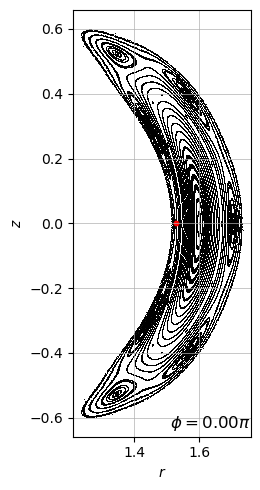

In [4]:
guess = [1.527, 0.]
ax.scatter(guess[0], guess[1], c='r', s=10)
fig

In [5]:
from pyoculus.solvers import FixedPoint
ps = ho.SimsoptBfieldProblem(ma.gamma()[0, 0], 0, 3, bs)

In [ ]:
gamma = ho.trace(bs, 40*2*np.pi, [5.72, 0, 0.68], tol=1e-9)

In [ ]:
from mayavi import mlab
for coil in coils:
    coil.plot(engine="mayavi", show=False)

mlab.plot3d(gamma[0, :], gamma[1, :], gamma[2, :], tube_radius=0.01, color=(0, 0, 1))

mlab.show()

In [6]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-12

pparams = dict()
pparams["nrestart"] = 0
pparams["tol"] = 1e-10
pparams['niter'] = 100

fp = FixedPoint(ps, pparams, integrator_params=iparams)
fp.compute(guess=guess, pp=3, qq=7, sbegin=1.4, send=2.0)

In [7]:
results = [list(p) for p in zip(fp.x, fp.y, fp.z)]

In [8]:
results

[[1.5270055748695273, 0.0, 2.736991636379275e-05],
 [1.3628371680136853, 0.0, -0.45230962008705516],
 [1.4409463083273089, 0.0, -0.4945725332171534],
 [1.6642082327031638, 0.0, -0.21189466312613692],
 [1.6642082326959111, 0.0, 0.2118946631464027],
 [1.4409463083155352, 0.0, 0.49457253322364503],
 [1.3628371680187426, 0.0, 0.4523096200769564],
 [1.5270055748695357, 0.0, -2.736995129861146e-05]]

In [ ]:
for rr in results:
    ax.scatter(rr[0], rr[2], marker="X", edgecolors="black", linewidths=1)
fig

#### Tracing stable and unstable manifolds

In [ ]:
from pyoculus.solvers import Manifold

In [ ]:
manif =  Manifold(fp, ps)

In [ ]:
manif.compute()

In [ ]:
fig = pickle.load(open("../output/poincare_figure_ncsx.pickle", "rb"))
ax = fig.get_axes()[0]

In [ ]:
for yy in out.y.T:
    yy = yy.reshape(-1, 2)
    ax.scatter(yy[:, 0], yy[:, 1], marker=".", s=1, c="blue")

# plt.xlim(1.2, 1.8)
# plt.ylim(-0.7, 0.7)

In [ ]:
# ax.set_xlim(1.2, 1.8)
# ax.set_ylim(-0.7, 0.7)
# ax.set_xlim(1.2, 1.8)
# ax.set_ylim(-0.1, 0.7)

fig

#### Finding fix-point

In [ ]:
fig = pickle.load(open("../output/poincare_figure_GYM000+1750_black.pickle", "rb"))
ax = fig.get_axes()[0]

In [ ]:
guess = [5.72, 0.68]
ax.scatter(guess[0], guess[1], c='r', s=10)
fig

In [ ]:
from pyoculus.solvers import FixedPoint
ps = ho.SimsoptBfieldProblem(ma.gamma()[0, 0], 0, 5, bs)

In [ ]:
gamma = ho.trace(bs, 40*2*np.pi, [5.72, 0, 0.68], tol=1e-9)

In [ ]:
from mayavi import mlab
for coil in coils:
    coil.plot(engine="mayavi", show=False)

mlab.plot3d(gamma[0, :], gamma[1, :], gamma[2, :], tube_radius=0.01, color=(0, 0, 1))

mlab.show()

In [ ]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-7

pparams = dict()
pparams["nrestart"] = 0
pparams["tol"] = 1e-7
pparams['niter'] = 100

fp = FixedPoint(ps, pparams, integrator_params=iparams)
fp.compute(guess=guess, pp=5, qq=4, sbegin=5.2, send=6.2, tol = 1e-8)

In [ ]:
results = [list(p) for p in zip(fp.x, fp.y, fp.z)]

In [ ]:
results

In [ ]:
for rr in results:
    ax.scatter(rr[0], rr[2], marker="X", edgecolors="black", linewidths=1)
fig

In [ ]:
rr = np.array(record)
ax.plot(rr[:, 0], rr[:, 1], "o", markersize=1)
fig

In [ ]:
for rr in record:
    plt.scatter(rr[0], rr[2], marker="x")

In [ ]:
fig = pickle.load(open("../output/poincare_figure_GYM000+1750_black.pickle", "rb"))

In [ ]:
ax = fig.get_axes()[0]
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'black']

for i, p in enumerate(fieldlines_phi_hits):
    for rr in p:
        ax.scatter(rr[2], rr[4], marker="X", color=colors[i % len(colors)], linewidths=1)

In [ ]:
fig

In [ ]:
for rr in r:
    plt.scatter(rr[0], rr[1], marker="X", edgecolors="black", linewidths=1)


In [ ]:
ho.poincare(bs, np.atleast_2d(r[1]), [0], sc_fieldline, plot = False, tmax = 22, tol = 1e-10)

In [ ]:
r.append(np.array([5.95395959e+00, 5.85198574e-01]))

In [ ]:
for rr in r:
    plt.scatter(rr[0], rr[1], marker="X", edgecolors="black", linewidths=1)